# Post-processing of stress and wave data for UQ

In [31]:
from asist.utility import binavg, running_mean, power_spectrum
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.signal import detrend
from scipy.stats import beta
from sustain_drag_2020.irgason import read_irgason_from_toa5, eddy_covariance_flux, rotate
from sustain_drag_2020.udm import read_udm_from_toa5
from sustain_drag_2020.fetch import fetch
import warnings
warnings.filterwarnings('ignore')

In [2]:
def eddy_covariance_flux_time_subset(irg, time, t0, t1):
    """Eddy covariance flux from IRGASON, 
    for a time subset between t0 and t1."""
    max_u_gust = 10
    max_w_gust = 5

    mask = (time >= t0) & (time <= t1)
    u, v, w = irg['u'][mask][:], irg['v'][mask][:], irg['w'][mask][:]

    # clean up
    um, vm, wm = np.nanmean(u), np.nanmean(v), np.nanmean(w)
    u[u > um + max_u_gust] = um + max_u_gust
    u[u < um - max_u_gust] = um - max_u_gust
    v[v > vm + max_u_gust] = vm + max_u_gust
    v[v < vm - max_u_gust] = vm - max_u_gust
    w[w > wm + max_w_gust] = wm + max_w_gust
    w[w < wm - max_w_gust] = wm - max_w_gust

    # horizontal velocity
    u = np.sqrt(u**2 + v**2)

    # rotate
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)

    # time average
    U, W = np.nanmean(u), np.nanmean(w)

    up, wp = u - U, w - W
    Ustd, Wstd = np.nanstd(u), np.nanstd(w)
    uw = np.nanmean(up * wp)

    return U, Ustd, Wstd, uw

## Wind and stress data

In [3]:
# Experiment 2019-11-21
DATAPATH = '/home/milan/Work/sustain/data/sustain-nsf-2019/20191121'
irgason_files = glob.glob(DATAPATH + '/TOA5_SUSTAIN_Wind.FAST*.dat')
start_time = datetime(2019, 11, 21, 16, 10)

irgason_time, irg1, irg2 = read_irgason_from_toa5(irgason_files)

Reading  TOA5_SUSTAIN_Wind.FAST_635_2019_11_21_1600.dat
Reading  TOA5_SUSTAIN_Wind.FAST_636_2019_11_21_1700.dat
Reading  TOA5_SUSTAIN_Wind.FAST_637_2019_11_21_1800.dat
Processing IRGASON time series..


In [4]:
irg1

{'u': array([-0.6974536, -0.6805043, -0.7712387, ..., -0.5724771, -0.5019378,
        -0.5241598]),
 'v': array([-0.06215607, -0.02423258, -0.1218228 , ..., -0.08222381,
        -0.1241984 , -0.1021255 ]),
 'w': array([0.02696056, 0.07308903, 0.050403  , ..., 0.02362216, 0.02997191,
        0.02676034]),
 'T': array([25.49269, 25.54745, 25.57636, ..., 24.76818, 24.73702, 24.76656])}

In [5]:
def sample_stress_sequential(irgason_data, time, fan, run_seconds, sample_seconds):
    """Sequentially sample IRGASON data and compute stress over given sample intervals."""
    nfan = len(fan)
    nbins = run_seconds // sample_seconds
    U = np.zeros((nfan, nbins))
    uw = np.zeros((nfan, nbins))
    for n, f in enumerate(fan):
        print('Computing stress for fan = %2i Hz' % f)
        for i in range(nbins):
            t0 = start_time + timedelta(seconds=n * run_seconds + i * sample_seconds)
            t1 = t0 + timedelta(seconds=sample_seconds)
            U[n,i], Ustd, Wstd, uw[n,i] = eddy_covariance_flux_time_subset(irgason_data, time, t0, t1)
    return U, uw

In [6]:
def sample_stress_uniform(irgason_data, time, fan, run_seconds, sample_seconds, nsamples):
    """Uniform-randomly sample IRGASON data and compute stress over given sample intervals."""
    nfan = len(fan)
    U = np.zeros((nfan, nsamples))
    uw = np.zeros((nfan, nsamples))
    for n, f in enumerate(fan):
        print('Computing stress for fan = %2i Hz' % f)
        sample_start_offset_seconds = np.random.uniform(size=nsamples) * (run_seconds - sample_seconds)
        for i in range(nsamples):
            t0 = start_time + timedelta(seconds=n * run_seconds + sample_start_offset_seconds[i])
            t1 = t0 + timedelta(seconds=sample_seconds)
            U[n,i], Ustd, Wstd, uw[n,i] = eddy_covariance_flux_time_subset(irgason_data, time, t0, t1)
    return U, uw

In [7]:
# fan speed and duration and sampling interval
fan = range(0, 65, 5)
run_seconds = 600
sample_seconds = 10

In [8]:
U_seq, uw_seq = sample_stress_sequential(irg1, irgason_time, fan, run_seconds, sample_seconds)

Computing stress for fan =  0 Hz
Computing stress for fan =  5 Hz
Computing stress for fan = 10 Hz
Computing stress for fan = 15 Hz
Computing stress for fan = 20 Hz
Computing stress for fan = 25 Hz
Computing stress for fan = 30 Hz
Computing stress for fan = 35 Hz
Computing stress for fan = 40 Hz
Computing stress for fan = 45 Hz
Computing stress for fan = 50 Hz
Computing stress for fan = 55 Hz
Computing stress for fan = 60 Hz


In [9]:
U_rand, uw_rand = sample_stress_uniform(irg1, irgason_time, fan, run_seconds, sample_seconds, 100)

Computing stress for fan =  0 Hz
Computing stress for fan =  5 Hz
Computing stress for fan = 10 Hz
Computing stress for fan = 15 Hz
Computing stress for fan = 20 Hz
Computing stress for fan = 25 Hz
Computing stress for fan = 30 Hz
Computing stress for fan = 35 Hz
Computing stress for fan = 40 Hz
Computing stress for fan = 45 Hz
Computing stress for fan = 50 Hz
Computing stress for fan = 55 Hz
Computing stress for fan = 60 Hz


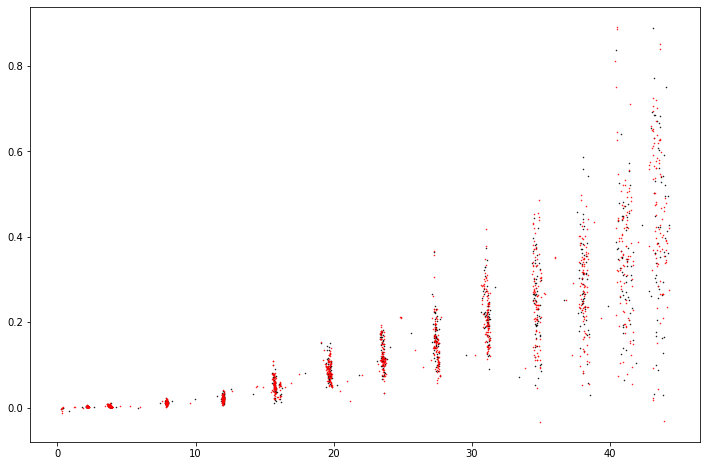

In [10]:
fig = plt.figure(figsize=(12, 8))
plt.plot(U_seq, uw_seq, 'k.', ms=1)
plt.plot(U_rand, uw_rand, 'r.', ms=1)

Text(0, 0.5, "$-\\overline{u'w'}$ [$m^2/s^2$]")

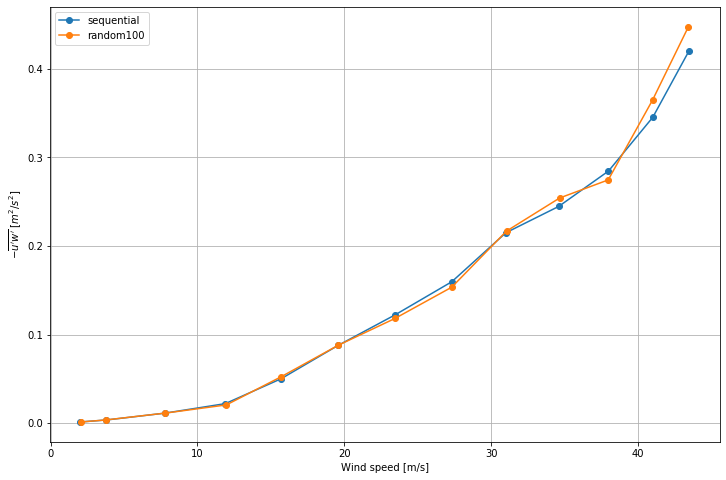

In [13]:
fig = plt.figure(figsize=(12, 8))
plt.plot(np.nanmean(U_seq, 1), np.nanmean(uw_seq, 1), marker='o', label='sequential')
plt.plot(np.nanmean(U_rand, 1), np.nanmean(uw_rand, 1), marker='o', label='random100')
plt.legend()
plt.grid()
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")

In [14]:
def normalize(x):
    xnorm = (x - np.min(x)) / (np.max(x) - np.min(x))
    xnorm[xnorm < 1e-6] = 1e-6
    xnorm[xnorm > 1 - 1e-6] = 1 - 1e-6
    return xnorm


def moments_fit(x):
    xmean = np.mean(x)
    xvar = np.var(x)
    alpha = xmean * (xmean * (1 - xmean) - xvar) / xvar
    beta = (xmean - 1) * (xmean * (xmean - 1) + xvar) / xvar
    return alpha, beta


def beta_pdf(x, fitting_type='mle', floc=0, fscale=1):
    """Returns alpha and beta parameters from a beta distribution."""
    num_runs = x.shape[0]
    aa = np.zeros((num_runs))
    bb = np.zeros((num_runs))
    for n in range(num_runs):
        xnorm = normalize(x[n,:][~np.isnan(x[n,:])])
        if fitting_type == 'mle':
            aa[n], bb[n], loc, scale = beta.fit(xnorm, floc=floc, fscale=fscale)
        elif fitting_type == 'moments':
            aa[n], bb[n] = moments_fit(xnorm)
        else:
            raise ValueError('fitting_type not supported')
    return aa, bb

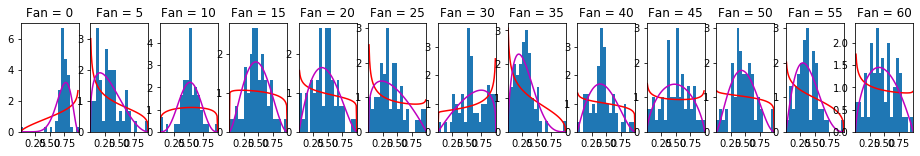

In [16]:
aa_mle_seq, bb_mle_seq = beta_pdf(uw_seq, 'mle')
aa_mom_seq, bb_mom_seq = beta_pdf(uw_seq, 'moments')

fig = plt.figure(figsize=(16, 2))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    data = normalize(uw_seq[n,:][~np.isnan(uw_seq[n,:])])
    #data = uw[n,:][~np.isnan(uw[n,:])]
    plt.hist(data, 20, density=True)
    x = np.linspace(0, 1, 100)
    #x = np.linspace(np.min(data), np.max(data), 100)
    plt.plot(x, beta.pdf(x, aa_mle_seq[n], bb_mle_seq[n]), 'r-', label='mle')
    plt.plot(x, beta.pdf(x, aa_mom_seq[n], bb_mom_seq[n]), 'm-', label='mom')
    plt.xlim(np.min(data), np.max(data))
    plt.title('Fan = ' + str(fan[n]))

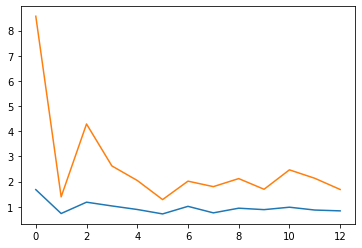

In [17]:
plt.plot(aa_mle_seq)
plt.plot(aa_mom_seq)

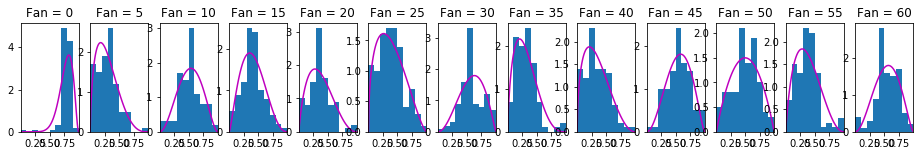

In [20]:
#aa_mle_rand, bb_mle_rand = beta_pdf(uw_rand, 'mle') # fails to converge for 10-s samples
aa_mom_rand, bb_mom_rand = beta_pdf(uw_rand, 'moments')

fig = plt.figure(figsize=(16, 2))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    data = normalize(uw_rand[n,:][~np.isnan(uw_rand[n,:])])
    plt.hist(data, 10, density=True)
    x = np.linspace(0, 1, 100)
    #plt.plot(x, beta.pdf(x, aa_mle_rand[n], bb_mle_rand[n]), 'r-', label='mle')
    plt.plot(x, beta.pdf(x, aa_mom_rand[n], bb_mom_rand[n]), 'm-', label='mom')
    plt.xlim(np.min(data), np.max(data))
    plt.title('Fan = ' + str(fan[n]))

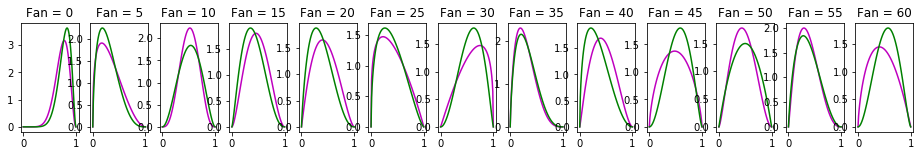

In [21]:
fig = plt.figure(figsize=(16, 2))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    #data = normalize(uw1000[n,:][~np.isnan(uw1000[n,:])])
    #plt.hist(data, 50, density=True)
    x = np.linspace(0, 1, 100)
    plt.plot(x, beta.pdf(x, aa_mom_seq[n], bb_mom_seq[n]), 'm-')
    plt.plot(x, beta.pdf(x, aa_mom_rand[n], bb_mom_rand[n]), 'g-')
    plt.title('Fan = ' + str(fan[n]))

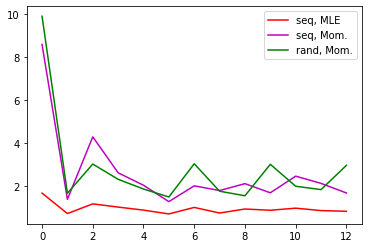

In [22]:
plt.plot(aa_mle_seq, 'r-', label='seq, MLE')
plt.plot(aa_mom_seq, 'm-', label='seq, Mom.')
#plt.plot(aa_mle_rand, 'b-', label='rand, MLE') # did not converge
plt.plot(aa_mom_rand, 'g-', label='rand, Mom.')
plt.legend()

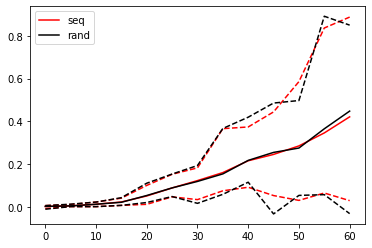

In [23]:
plt.plot(fan, np.min(uw_seq, axis=1), 'r--')
plt.plot(fan, np.max(uw_seq, axis=1), 'r--')
plt.plot(fan, np.mean(uw_seq, axis=1), 'r-', label='seq')
plt.plot(fan, np.min(uw_rand, axis=1), 'k--')
plt.plot(fan, np.max(uw_rand, axis=1), 'k--')
plt.plot(fan, np.mean(uw_rand, axis=1), 'k-', label='rand')
plt.legend()

In [24]:
def dist_ks(x, alpha, beta):
    x_sorted = np.sort(x)
    cdf = beta.cdf(x, alpha, beta)
    xx = np.linspace(1 / x.size, 1, x.size)
    series1 = np.abs(cdf - xx)
    series2 = np.abs(cdf - xx + 1 / x.size)
    return np.max(np.max(series1), np.max(series2))

## Processing waves from UDM

In [25]:
def elevation_from_udm(x):
    """Remove spikes and offset."""
    xx = x[:]
    for n in range(5):
        for i in range(1, xx.size-1):
            if xx[i] > 1.6:
                xx[i] = 0.5 * (xx[i-1] + xx[i+1])
    offset = np.mean(xx[:1200])
    xx = offset - xx
    return xx

In [26]:
# data parameters
files = glob.glob(DATAPATH + '/TOA5_SUSTAIN_ELEVx6_20Hz*.dat')

In [27]:
# read UDM data from TOA5 files
udm_time, u1, u2, u3, u4, u5, u6 = read_udm_from_toa5(files)

Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1275_2019_11_21_1600.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1276_2019_11_21_1700.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1277_2019_11_21_1800.dat


In [28]:
u1

array([1.170183, 1.17016 , 1.170596, ..., 1.322138, 1.321949, 1.322125])

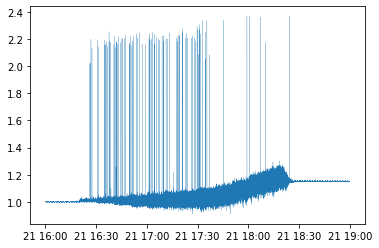

In [30]:
plt.plot(udm_time, u3, lw=0.2)

In [32]:
# map UDM arrays to sequential positions in the tank
udm = np.zeros((5, u1.size))
udm[0,:] = u6[:]
udm[1,:] = u5[:]
udm[2,:] = u1[:]
udm[3,:] = u3[:]
udm[4,:] = u4[:]

udm_fetch = fetch['udm']

In [37]:
udm_fetch

array([ 3.34,  7.08,  9.87, 11.94, 14.9 ])

In [34]:
# 10-minute time windows for each run; 
t0 = [start_time + timedelta(seconds=n * run_seconds)
    for n in range(len(fan))]
t1 = [start_time + timedelta(seconds=(n + 1) * run_seconds)
    for n in range(len(fan))]

Computing wave spectra for fan speed  5 Hz
Computing wave spectra for fan speed  10 Hz
Computing wave spectra for fan speed  15 Hz
Computing wave spectra for fan speed  20 Hz
Computing wave spectra for fan speed  25 Hz
Computing wave spectra for fan speed  30 Hz
Computing wave spectra for fan speed  35 Hz
Computing wave spectra for fan speed  40 Hz
Computing wave spectra for fan speed  45 Hz
Computing wave spectra for fan speed  50 Hz
Computing wave spectra for fan speed  55 Hz
Computing wave spectra for fan speed  60 Hz


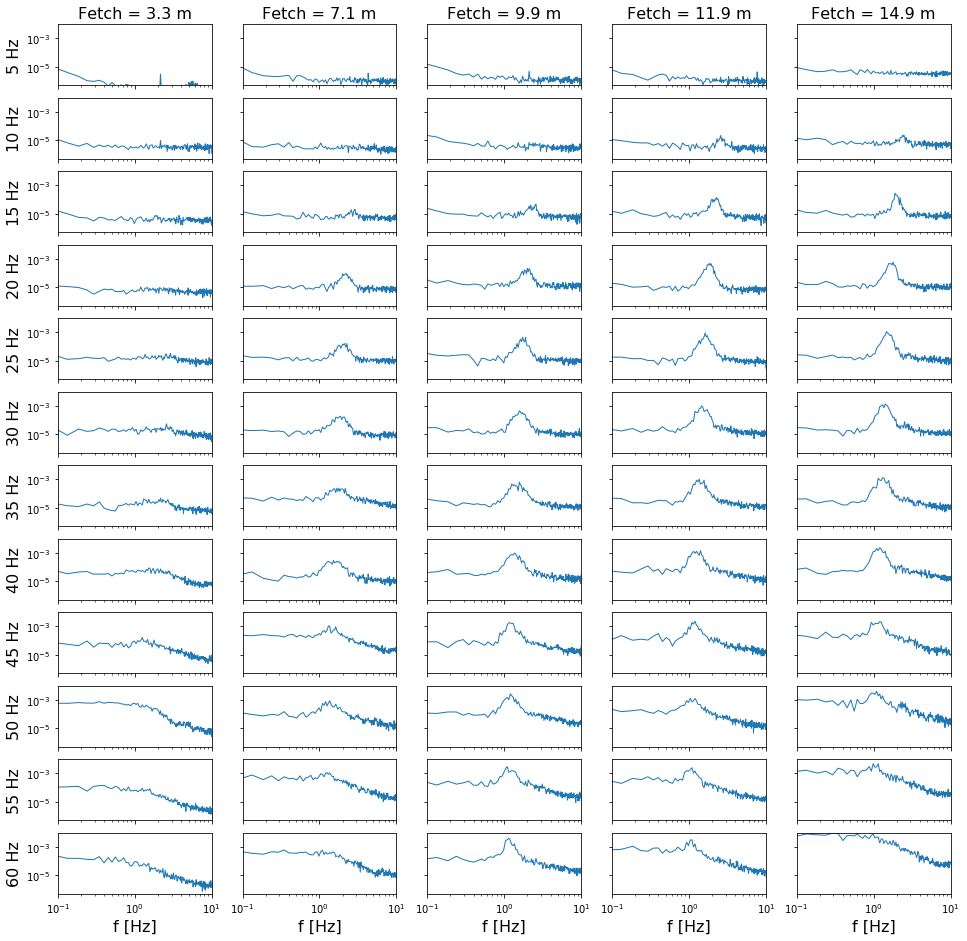

In [39]:
fig = plt.figure(figsize=(16, 16))
for n in range(1, len(fan)):
    print('Computing wave spectra for fan speed ', fan[n], 'Hz')
    mask = (udm_time >= t0[n]) & (udm_time <= t1[n])
    for i in range(5):
        ax = plt.subplot2grid((12, 5), (n - 1, i))
        e = detrend(elevation_from_udm(udm[i,mask]))
        F, f, df = power_spectrum(e, 1 / 20, binsize=32)
        ax.loglog(f, F, lw=1)
        plt.xlim(1e-1, 1e1)
        plt.ylim(5e-7, 1e-2)
        if n == 1: plt.title('Fetch = %.1f m' % udm_fetch[i], fontsize=16)
        if n == 12: plt.xlabel('f [Hz]', fontsize=16)
        if n != 12: ax.set_xticklabels([])
        if i == 0: plt.ylabel(str(fan[n]) + ' Hz', fontsize=16)
        if i != 0: ax.set_yticklabels([])

In [40]:
nsamples = 100

sample_seconds = 10

num_runs = len(fan)

E = np.zeros((num_runs, nsamples))
Tm = np.zeros((num_runs, nsamples))
Tp = np.zeros((num_runs, nsamples))

for n in range(num_runs):
    print('Computing wave spectra for fan speed ', fan[n], 'Hz')
    sample_start_offset_seconds = np.random.uniform(size=nsamples) * (run_seconds - sample_seconds)
    for i in range(nsamples):
        t0 = start_time + timedelta(seconds=n * run_seconds + sample_start_offset_seconds[i])
        t1 = t0 + timedelta(seconds=sample_seconds)
        mask = (udm_time >= t0) & (udm_time < t1)
        e = detrend(elevation_from_udm(udm[3,mask]))
        F, f, df = power_spectrum(e, 1 / 20, binsize=32)
        E[n,i] = np.sum(F) * df
        Tm[n,i] = E[n,i] / np.sum(F * f * df)
        Tp[n,i] = np.sum(F**4) / np.sum(F**4 * f)

Computing wave spectra for fan speed  0 Hz
Computing wave spectra for fan speed  5 Hz
Computing wave spectra for fan speed  10 Hz
Computing wave spectra for fan speed  15 Hz
Computing wave spectra for fan speed  20 Hz
Computing wave spectra for fan speed  25 Hz
Computing wave spectra for fan speed  30 Hz
Computing wave spectra for fan speed  35 Hz
Computing wave spectra for fan speed  40 Hz
Computing wave spectra for fan speed  45 Hz
Computing wave spectra for fan speed  50 Hz
Computing wave spectra for fan speed  55 Hz
Computing wave spectra for fan speed  60 Hz


Text(0.5, 1.0, 'Total wave energy [$m^2$]')

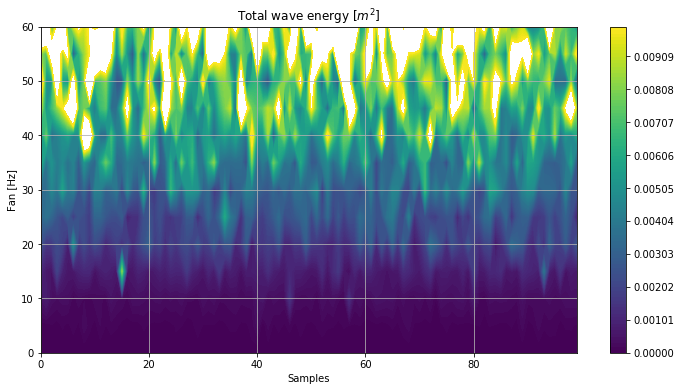

In [50]:
fig = plt.figure(figsize=(12, 6))
plt.contourf(range(nsamples), fan, E, np.linspace(0, 0.01, 100))
plt.colorbar()
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Fan [Hz]')
plt.title('Total wave energy [$m^2$]')

Text(0.5, 1.0, 'Mean period [s]')

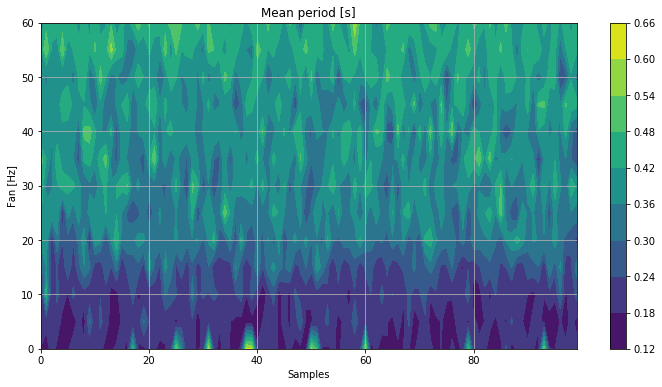

In [49]:
fig = plt.figure(figsize=(12, 6))
plt.contourf(range(nsamples), fan, Tm)
plt.colorbar()
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Fan [Hz]')
plt.title('Mean period [s]')

Text(0.5, 1.0, 'Peak period [s]')

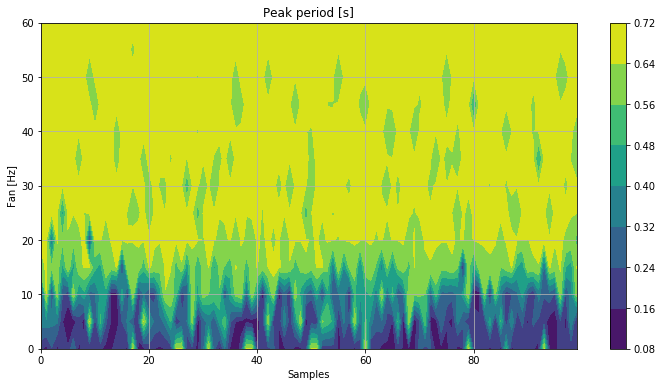

In [51]:
fig = plt.figure(figsize=(12, 6))
plt.contourf(range(nsamples), fan, Tp)
plt.colorbar()
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Fan [Hz]')
plt.title('Peak period [s]')

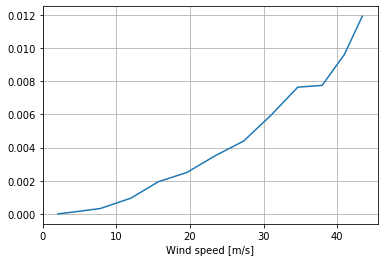

In [54]:
plt.plot(np.nanmean(U_rand, 1), np.nanmean(E, 1))
plt.xlabel('Wind speed [m/s]')
plt.grid()

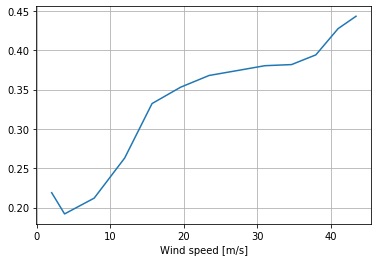

In [53]:
plt.plot(np.nanmean(U_rand, 1), np.nanmean(Tm, 1))
plt.xlabel('Wind speed [m/s]')
plt.grid()

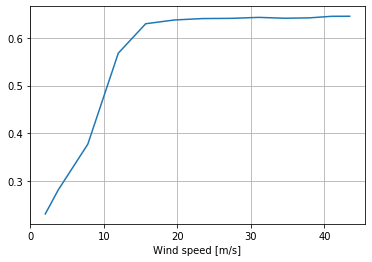

In [55]:
plt.plot(np.nanmean(U_rand, 1), np.nanmean(Tp, 1))
plt.xlabel('Wind speed [m/s]')
plt.grid()